In [1]:
import tensorflow as tf 
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist, mnist
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from utils import *
!rm -rf logs/fit

# Loading data
We start with the MNIST. We already now from last lesson how easy (or difficult) it is to get a certain performance, so we can evaluate the impact of the different types of activations, batchnorm and activations.

In [2]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()
from sklearn.model_selection import train_test_split
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.4, random_state=42)

In [3]:
X_train.shape

(60000, 28, 28)

## Baseline
We start with a baselinemodel, that is the result from the hypertuning of last lesson. Note how I put the rescaling inside the model itself.

In [4]:
result = {}
score = {}

In [5]:
%%time # takes about 1min30s
tf.random.set_seed(42) 
# this random.set_seed makes sure that the random initialization 
# of the weight is every time the same.
# normally, you won't need that, but this makes sure 
# that the lesson has the exact same output, every time you run it.
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['base'] = model.fit(X_train, y_train, epochs=7, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['base'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1035 - accuracy: 0.9737
CPU times: user 1min 10s, sys: 13.7 s, total: 1min 24s
Wall time: 30.3 s


Note, that normally, you would set the epochs high (eg `epochs=-100`) and let the `EarlyStopping` interrupt the notebook. Because every epoch takes quite some time, I ran it once, and adjusted the runtime by reducing the amount of epochs. This just saves time when I need to rerun the lesson.

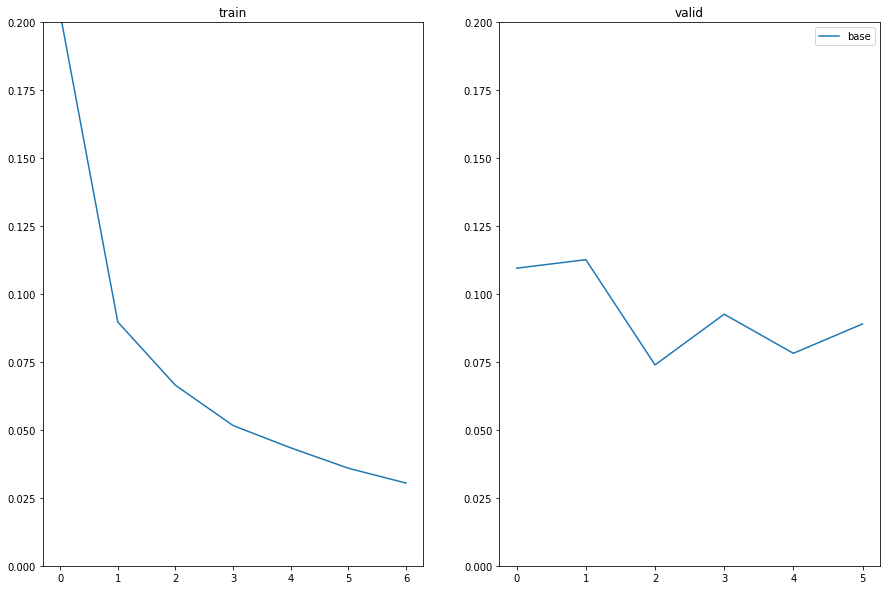

In [6]:
plot_results(result, ymax = 0.2)

## Activation functions
Let's try the SELU. We need the data to be scaled by a standard scaler, and our kernel intializer should be `lecun_normal`. Note that we have to remove the rescaling inside the model.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trains = scaler.fit_transform(X_train.reshape(len(X_train), -1))
X_valids = scaler.transform(X_valid.reshape(len(X_valid), -1))
X_tests = scaler.transform(X_test.reshape(len(X_test), -1))

In [8]:
%%time #takes about 1min15s
tf.random.set_seed(42)
model = Sequential([
    Dense(256, activation='selu', kernel_initializer='lecun_normal'),
    Dense(256, activation='selu', kernel_initializer='lecun_normal'),
    Dense(256, activation='selu', kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['selu']  = model.fit(X_trains, y_train, epochs=6, validation_data=(X_valids, y_valid), callbacks=[early_stop], verbose = 0)
score['selu'] = model.evaluate(X_tests, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9665
CPU times: user 1min, sys: 11.8 s, total: 1min 12s
Wall time: 26.5 s


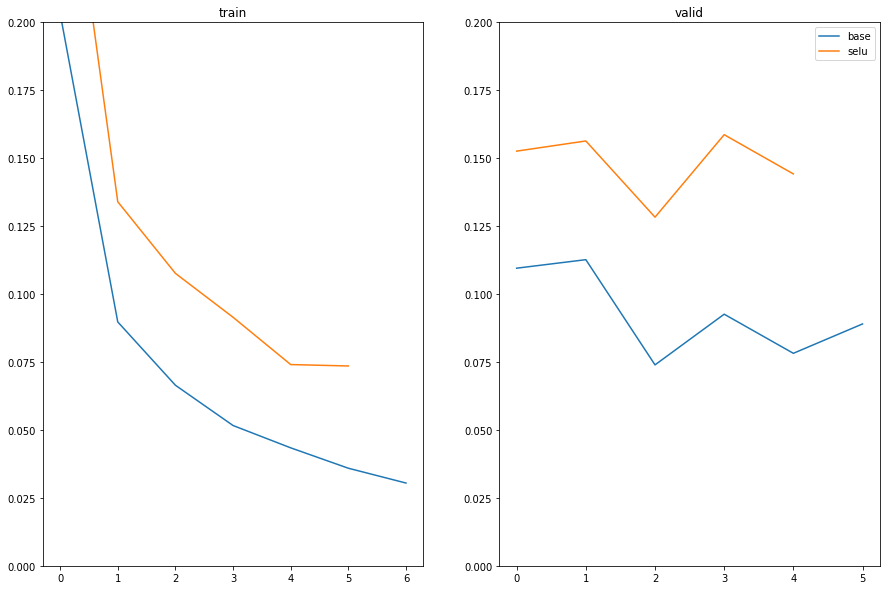

In [9]:
plot_results(result, ymin=0, ymax = 0.2)

In [10]:
np.mean(X_train), np.std(X_train)

(33.318421449829934, 78.56748998339798)

That's not really an improvement. A problem is that the data is not really normal distributed, with a mean of 33 and a std of 78. Tweaking that might give you better results, but for now we will leave it as it is. Let's try GELU.

In [11]:
%%time #takes about 1min20s
tf.random.set_seed(42)
from tensorflow_addons.layers import GELU

model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256),
    GELU(),
    Dense(256),
    GELU(),
    Dense(256),
    GELU(),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['gelu']  = model.fit(X_train, y_train, epochs=6, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['gelu'] = model.evaluate(X_test, y_test)

/opt/tljh/user/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.1 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last sol

125/125 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.9805
CPU times: user 1min 6s, sys: 13.7 s, total: 1min 20s
Wall time: 29.6 s


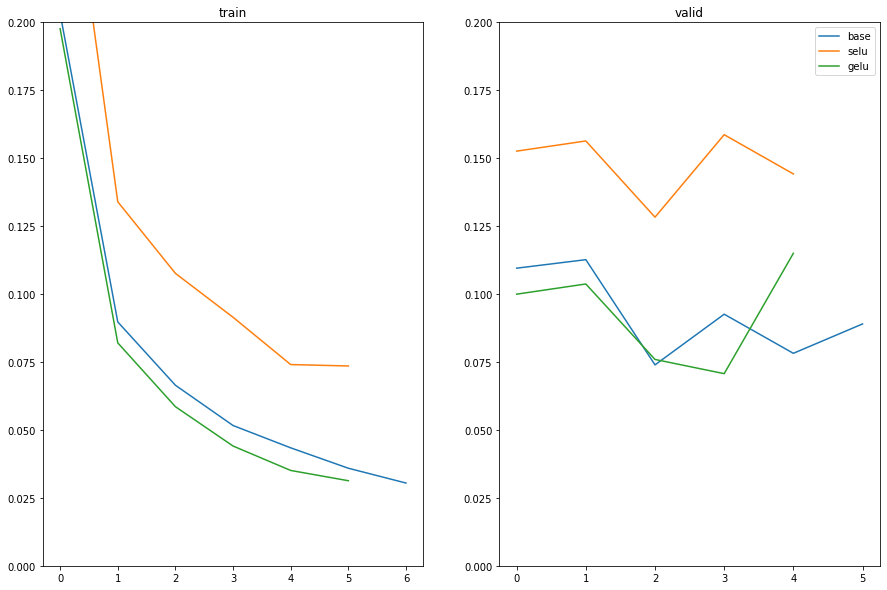

In [12]:
plot_results(result, ymin=0, ymax = 0.2)

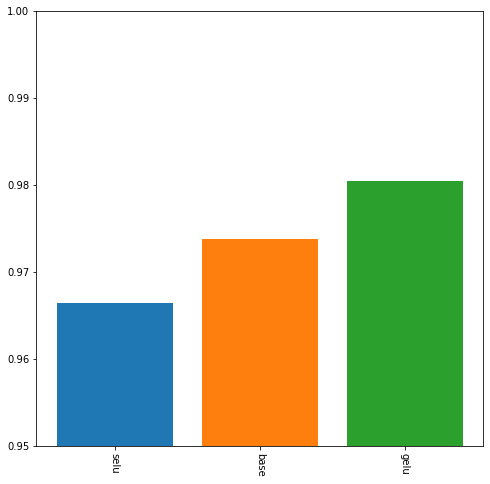

In [13]:
plot_scores(score, ymin=0.95)

That's a small improvement. However, this is also slightly random. Changing the `random_seed` might change this outcome. Note, we are talking about very small differences, in the order of tenths of a percent. Now let's try `elu`

In [14]:
%%time #takes about 1min15s
tf.random.set_seed(42)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256, activation='elu'),
    Dense(256, activation='elu'),
    Dense(256, activation='elu'),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['elu'] = model.fit(X_train, y_train, epochs=6, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['elu']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1295 - accuracy: 0.9690
CPU times: user 1min 2s, sys: 11.4 s, total: 1min 13s
Wall time: 27.3 s


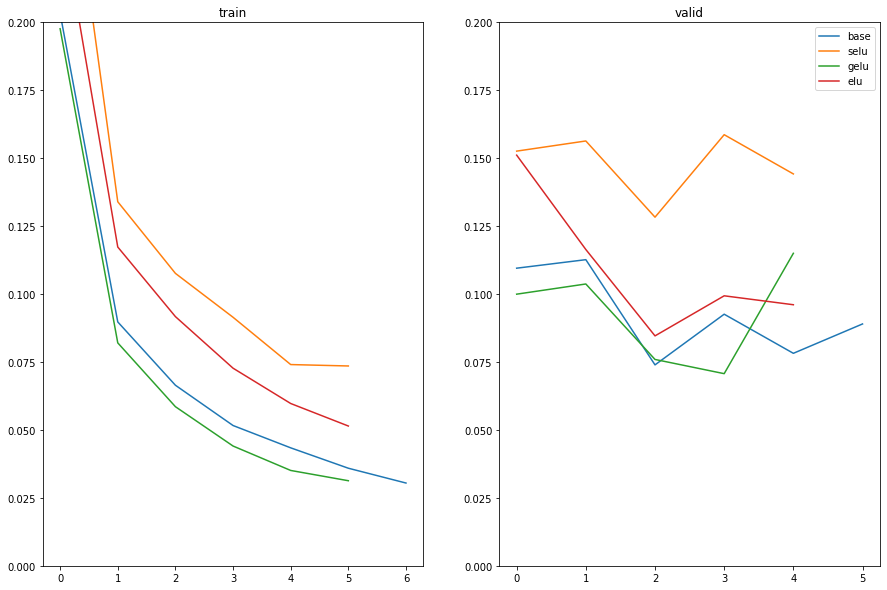

In [15]:
plot_results(result, ymin=0, ymax = 0.2)

And a `LeakyReLU`. Note how we have to do that: no activation specified in the `Dense` layer! Note that tweaking the alpha could improve the results.

In [26]:
%%time #takes about 1min30s
from tensorflow.keras.layers import LeakyReLU
tf.random.set_seed(42)
model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256),
    LeakyReLU(alpha=0.01),
    Dense(256),
    LeakyReLU(alpha=0.01),
    Dense(256),
    LeakyReLU(alpha=0.01),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['leaky']  = model.fit(X_train, y_train, epochs=7, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['leaky']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.9760
CPU times: user 1min 10s, sys: 14.1 s, total: 1min 24s
Wall time: 31.2 s


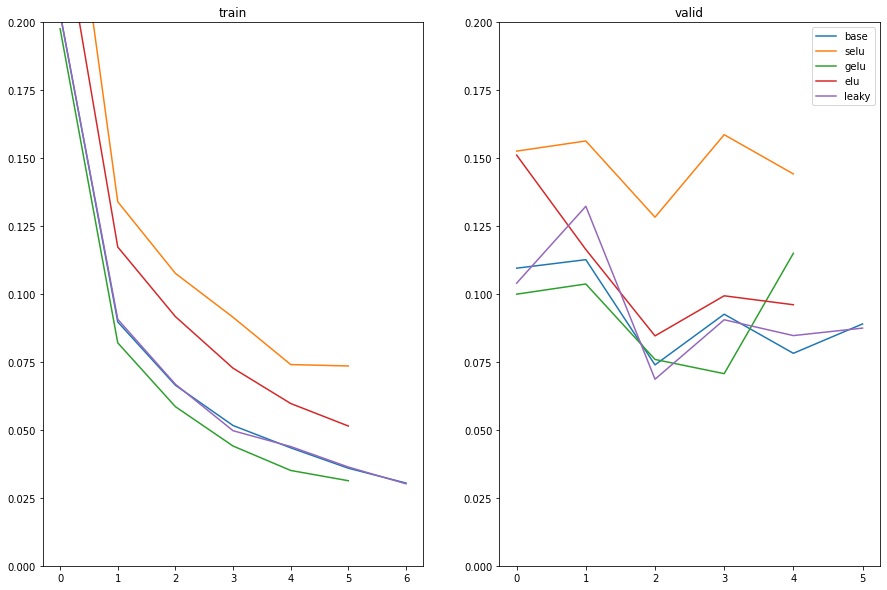

In [34]:
plot_results(result, ymin=0, ymax = 0.2)

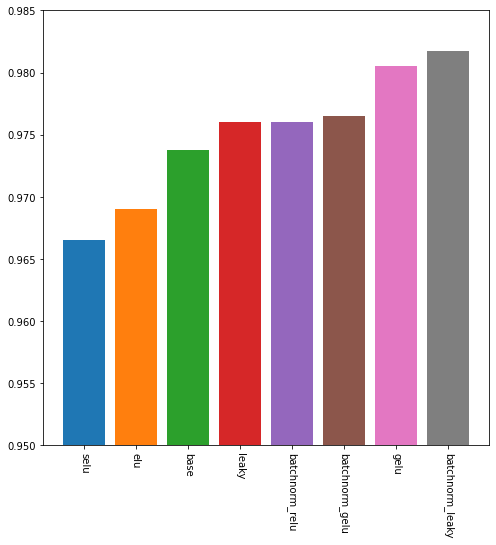

In [35]:
plot_scores(score, ymin=0.95, ymax=0.985)

Conclusion: we can improve slightly on the baseline model. Note that this is sensitive on random things. Initializing the weights differently might give different results. Also note how the baselinemodel is better on the validation set, than the leaky model, but on the testset the leaky model wins. 

## Batchnorm
Now, let's see what happens when we add a Batchnorm. First on our baseline model:

In [36]:
%%time #takes about 2min30s
tf.random.set_seed(42)
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['batchnorm_relu'] = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['batchnorm_relu']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9820
CPU times: user 2min 7s, sys: 26.5 s, total: 2min 33s
Wall time: 59.9 s


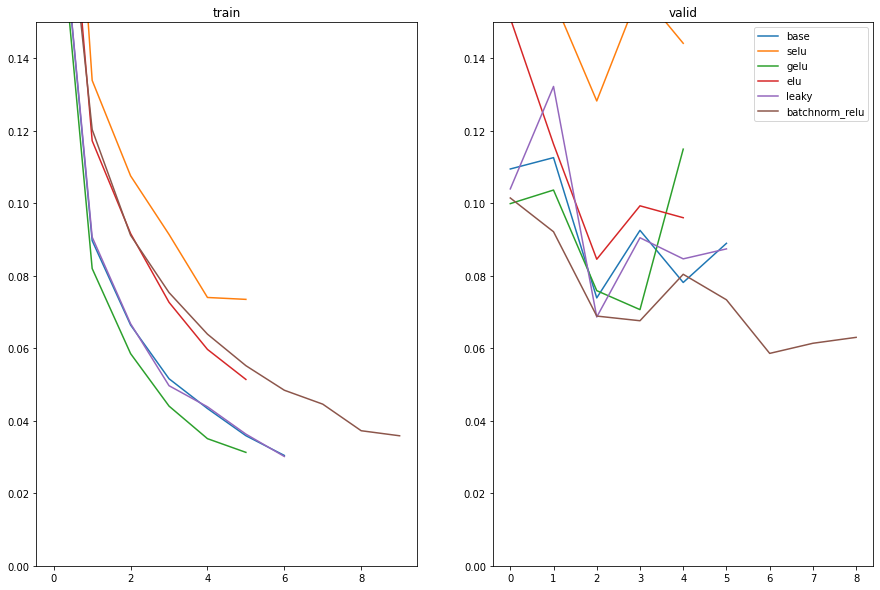

In [37]:
plot_results(result, ymin=0, ymax = 0.15)

That's an improvement! And, because we had reasonable results with GELU and LeakyReLU, let's try those too.

In [38]:
%%time # takes about 2min30s
tf.random.set_seed(42)
from tensorflow_addons.layers import GELU

model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256),
    GELU(),
    BatchNormalization(),
    Dense(256),
    GELU(),
    BatchNormalization(),
    Dense(256),
    GELU(),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['batchnorm_gelu']  = model.fit(X_train, y_train, epochs=9, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['batchnorm_gelu'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0765 - accuracy: 0.9768
CPU times: user 2min 4s, sys: 25.5 s, total: 2min 29s
Wall time: 58.7 s


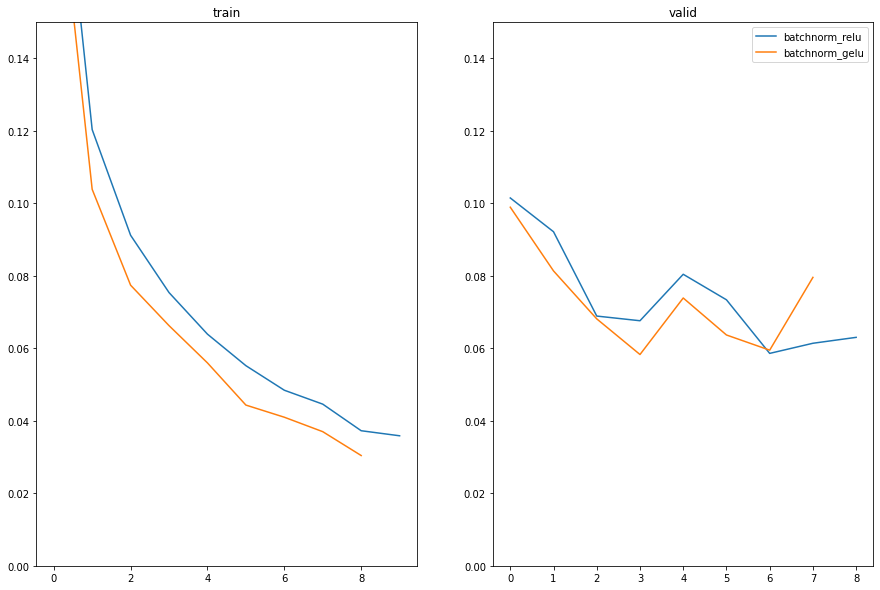

In [39]:
plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset='batch')

And with the LeakeReLU

In [40]:
%%time #takes about 2min30s
tf.random.set_seed(42)
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['batchnorm_leaky']  = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['batchnorm_leaky'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.9783
CPU times: user 2min 8s, sys: 25.4 s, total: 2min 33s
Wall time: 60 s


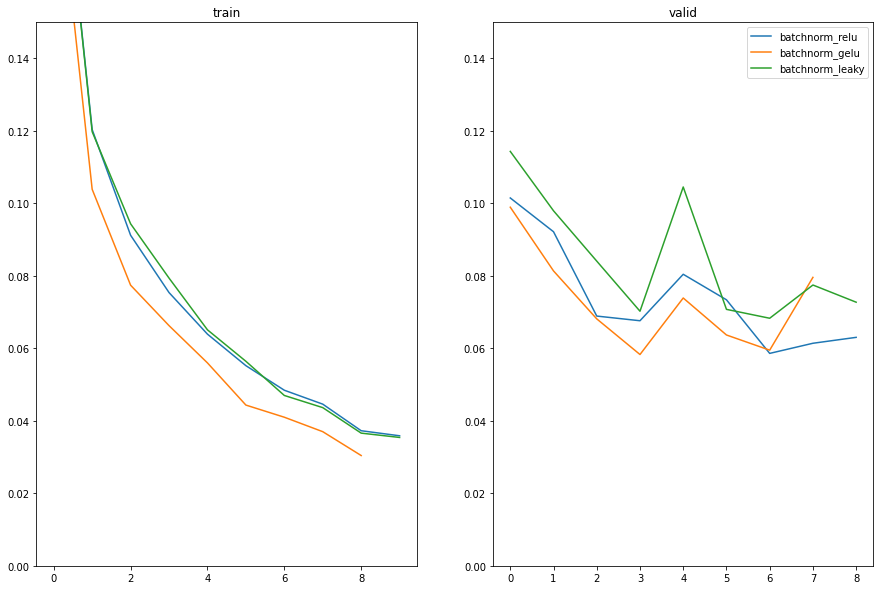

In [41]:
plot_results(result, ymin=0, ymax = 0.15, alpha = 0.2, yscale='linear', subset='batchnorm')

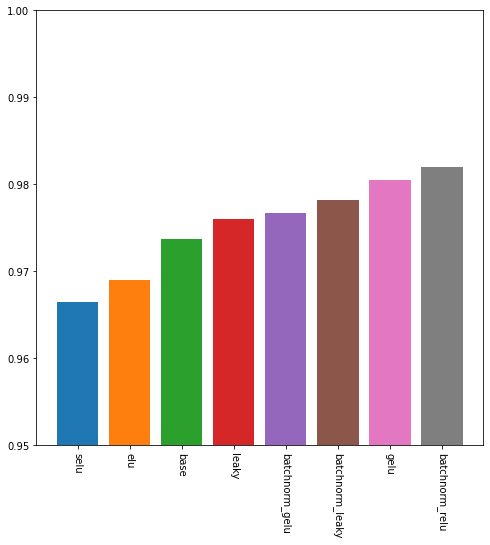

In [42]:
plot_scores(score, ymin=0.95, ymax=0.99)

I have had different results, when running this notebook mutitple times. It improves both the leaky and the relu, in this case the GELU gets slightly worse. Often, the batchnorm improves the results. While it might sometimes reduce the result, note that the differences for the MNIST are really small; we are talking about a few 'hard nuts'. Usually, adding `BatchNormalization` is a good idea.
Interestingly, we end up with `relu` again. This shows that, even though the function is really simple, it is often a great first pick.

## Dropout
Now, let's experiment with Dropout. We start with a single dropout layer, just before the last layer.

In [47]:
%%time # takes about 2min37s
tf.random.set_seed(42)

model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['batchnorm_relu_1dropout'] = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['batchnorm_relu_1dropout']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.9793
CPU times: user 2min 12s, sys: 25.4 s, total: 2min 37s
Wall time: 1min


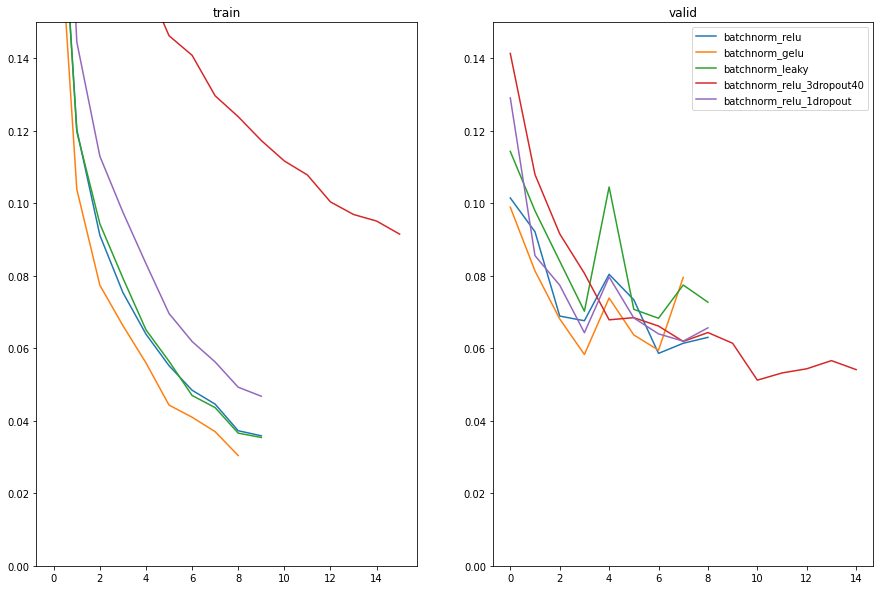

In [48]:
plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset='batch')

Now, let's add dropouts after every layer (except after the last).

In [49]:
%%time # takes about 4min total
tf.random.set_seed(42)

model = Sequential([
    Flatten(),
    Rescaling(1./255),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
result['batchnorm_relu_3dropout40'] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['batchnorm_relu_3dropout40']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9815
CPU times: user 3min 42s, sys: 39.6 s, total: 4min 21s
Wall time: 1min 39s


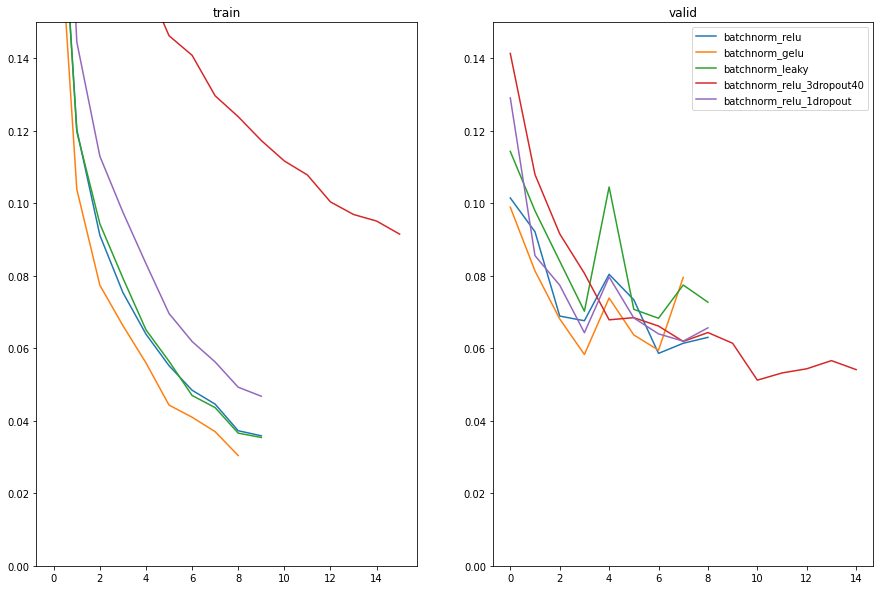

In [50]:
plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset = 'batch')

This might seem weird! The train goes worse, but the valid goes better! It's actually the best, so far. Note that it takes a lot more time to train, too.

Let's create a forloop to test different values of the dropout, to see what that does.

In [51]:
%%time
tf.random.set_seed(42)
drops = [0.3, 0.2, 0.1]
for drop in drops:
    name = 'batchnorm_relu_3dropout{0}'.format(int(drop*100))

    model = Sequential([
        Flatten(),
        Rescaling(1./255),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    
    result[name] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
    score[name] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9865
CPU times: user 19min 1s, sys: 3min 51s, total: 22min 53s
Wall time: 8min 43s


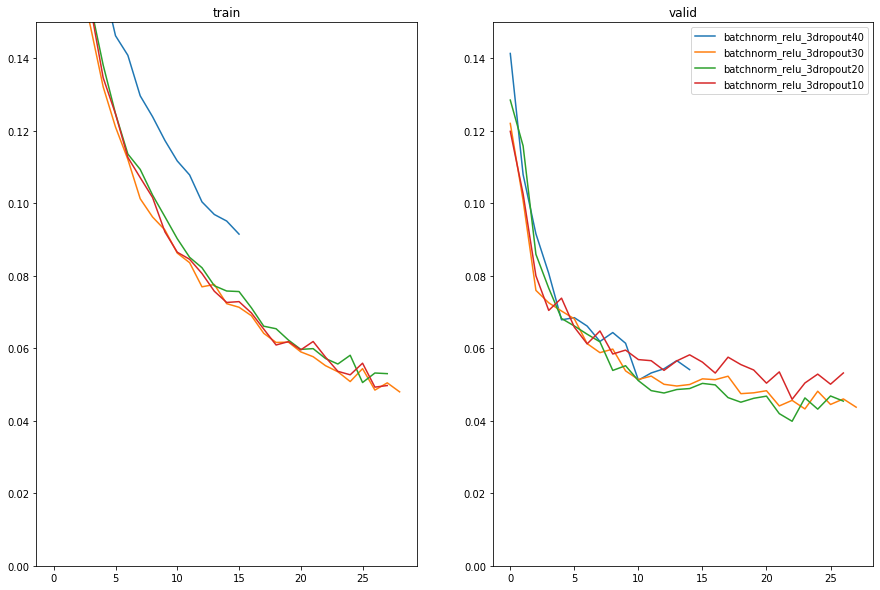

In [52]:
plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset = 'dropout[0-9]')

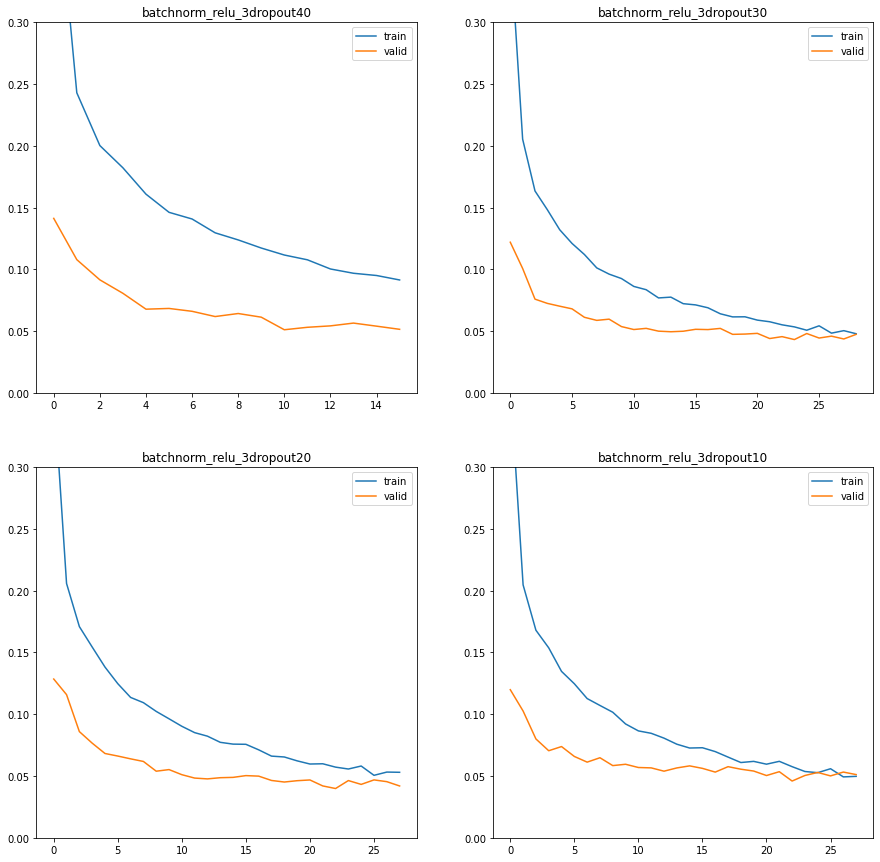

In [53]:
plot_results(result, grid=True, ymax = 0.3, subset='dropout[0-9]')

This result might suprise you. We can see that the training result is *worse* than the validation result with the dropout. That is something you normally don't expect! How does that make sense? Is the model underfitting, instead of overfitting? 

Well, actually, no. Or, it might. But it makes sense with dropout.

What we are seeing, is the impact of the dropout. Because the dropout drops random units during training, the train result will underperform, but it will give a better result during validation when there are no longer drops active.

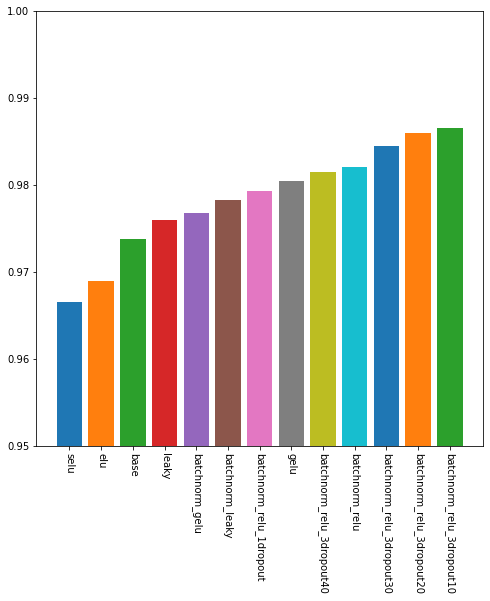

In [54]:
plot_scores(score, ymin=0.95)

With dropout, the batchnorm_relu is improved for rates of 30, 20 and 10%. We might get improvements with leaky or gelu too; try it out if you are curious!

 # Convolutions and Hypermodel

Next lesson, we will dive into the theory behind convolutions and maxpooling. For now, let's just try to add these new types of layers to see their effect.

- a Conv2D layer expects (as the name suggests) **2D data**, but with an amount of channels for color / grayscale. So, every example has the 3D shape (batchsize x height x width) which does not has a channel defined. So we need to add an additional dimension, to specify that we have just one channel for color. We can do this with either reshape, or just with `Input(shape=[28,28,1])`. We will end with a **4D shape** for all data, eg (batchsize x height x width x channels)
- We can tune the amount of filters (first argument) and the size of the kernel (second argument). In this example, I have fixated the kernelsize at 3, and set the amount of filters as a hyperparameters to be tuned by the model.
- After a convolution, you can add a MaxPool2D layer. Again, **3D shapes** are expected (2D image with 1D for channels).
- the amount of combinations of Conv2d and MaxPool2D is something that we will hypertune.
- After we are finished with convolutions & pooling, we want to pass the result to our Dense layers. However, they still expect the data to have a shape (batchsize x features), so we need to **flatten the 2D shape** into a 1D feature vector.
- For the Dense layers, we will add Batchnormalization and Dropouts. The amount of dropout is a hyperparameter to tune.

In [55]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def build_model(hp):
    input = Input(shape = [28,28, 1])
    x = Rescaling(1./255)(input)
    
    filters = hp.Int('filters', 16, 64, 4)
    x = Conv2D(filters, (3,3), activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    
    for i in range(hp.Int('conv_layers', 0, 2)):
        x = Conv2D(filters, (3,3), activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 320, 64)
    act = 'relu'
    drops = hp.Float('drops', 0.1, 0.4)
    leak = hp.Float('leak', 0, 0.2)

    x = Dense(units)(flat)
    x = LeakyReLU(alpha=leak)(x)
    x = BatchNormalization()(x)
    x = Dropout(drops)(x)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units)(x)
        x = LeakyReLU(alpha=leak)(x)
        x = BatchNormalization()(x)
        x = Dropout(drops)(x)
    
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [65]:
import kerastuner as kt
# takes about 10 minutes with max_epochs=5 and factor=3
# takes about 5 minutes with max_epochs=3 and factor=2

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=3, # increasing this increases the total amount of trials
    factor=2, # decreasing this will increase the amount of total trials
    seed=10, # adding a random seed here, guarantees you get the same outcome.
    hyperband_iterations=1, # this runs the hyperband multiple times, from scratch, when increased.
    overwrite=True, # overwrites old runs, so you don't need to remove the folder.
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, validation_data = (X_valid, y_valid), verbose=1)

Trial 8 Complete [00h 00m 51s]
val_loss: 0.04286082834005356

Best val_loss So Far: 0.03510458767414093
Total elapsed time: 00h 05m 06s
INFO:tensorflow:Oracle triggered exit


In [66]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'filters': 24, 'conv_layers': 1, 'units': 192, 'drops': 0.3046013681763934, 'leak': 0.12789473894406408, 'dense_layers': 2, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [57]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
cnn_model = tuner.get_best_models()[0]
cnn_model.summary()

{'filters': 32, 'conv_layers': 1, 'units': 320, 'drops': 0.12710195628080487, 'leak': 0.1931838376049888, 'dense_layers': 1, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
____________________________________________

In [67]:
%%time 
tf.random.set_seed(42)
result['hyper'] = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)

CPU times: user 10min 29s, sys: 54 s, total: 11min 23s
Wall time: 2min 39s


In [68]:
score['hyper'] = cnn_model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 4ms/step - loss: 0.0366 - accuracy: 0.9925


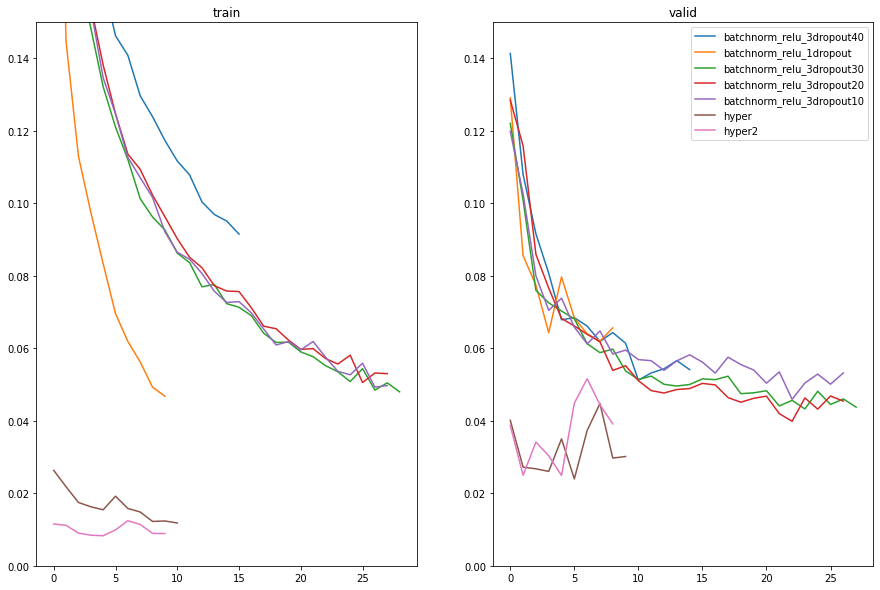

In [69]:
plot_results(result, ymin=0, ymax = 0.15, subset='drop|hyper')

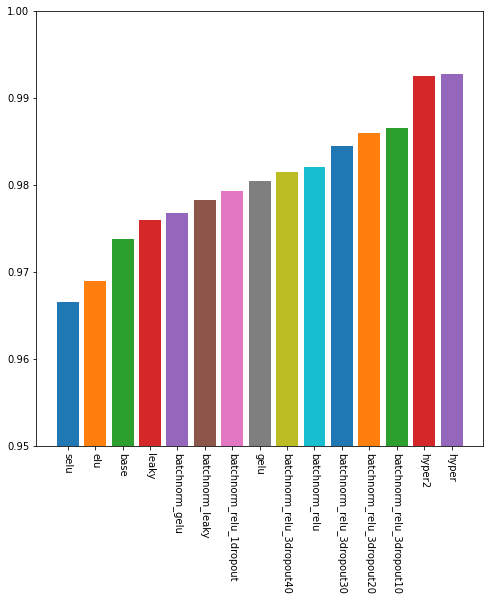

In [71]:
plot_scores(score, ymin=0.95)

In [75]:
from kerastuner import HyperParameters
hp = HyperParameters()
# you can fix some of the values to decrease the size of the search space
# lets fixate the units and the conv_layers, because I'm most confident about those values.
# This way, the hyperband can focus on exploring the rest
hp.Fixed('units', value=256)
hp.Fixed('conv_layers', value=1)

# takes about 5 minutes with max_epochs=3 and factor=2
tuner = kt.Hyperband(
    build_model,
    hyperparameters=hp, # this overwrites the old values with the fixed values
    tune_new_entries=True, # this allows the rest that isn't defined to be trained
    objective='val_loss',
    max_epochs=3, # increasing this increases the total amount of trials
    factor=2, # decreasing this will increase the amount of total trials
    seed=10, # adding a random seed here, guarantees you get the same outcome.
    hyperband_iterations=1, # this runs the hyperband multiple times, from scratch, when increased.
    overwrite=True, # overwrites old runs, so you don't need to remove the folder.
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, validation_data = (X_valid, y_valid), verbose=1)

Trial 8 Complete [00h 00m 55s]
val_loss: 0.03137427195906639

Best val_loss So Far: 0.028563549742102623
Total elapsed time: 00h 05m 26s
INFO:tensorflow:Oracle triggered exit


In [76]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]

tf.random.set_seed(42)
result['hyper3'] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop], verbose = 0)
score['hyper3'] = model.evaluate(X_test, y_test)

{'units': 256, 'conv_layers': 1, 'filters': 24, 'drops': 0.10368347421939264, 'leak': 0.015484356770660825, 'dense_layers': 3, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
125/125 [==============================] - 0s 4ms/step - loss: 0.0401 - accuracy: 0.9893


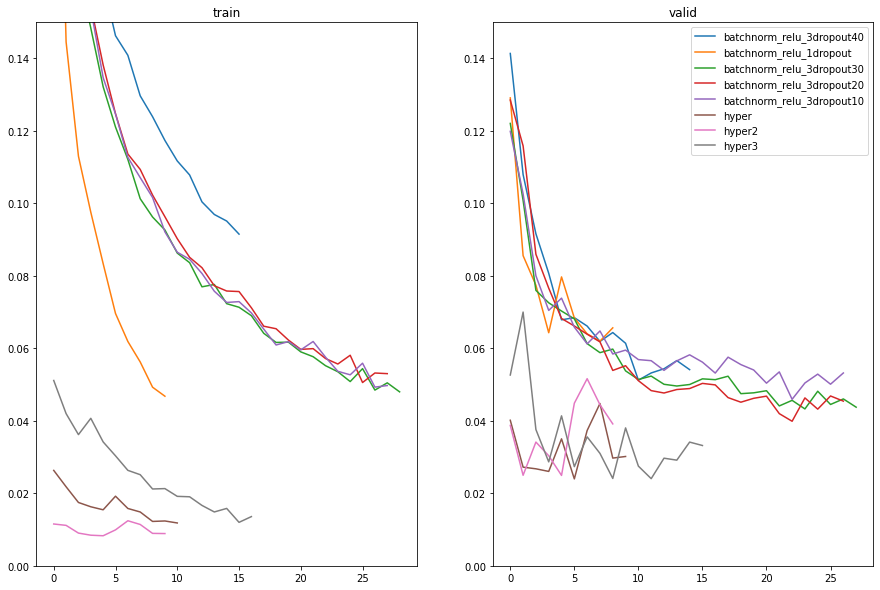

In [77]:
plot_results(result, ymin=0, ymax = 0.15, subset='drop|hyper')

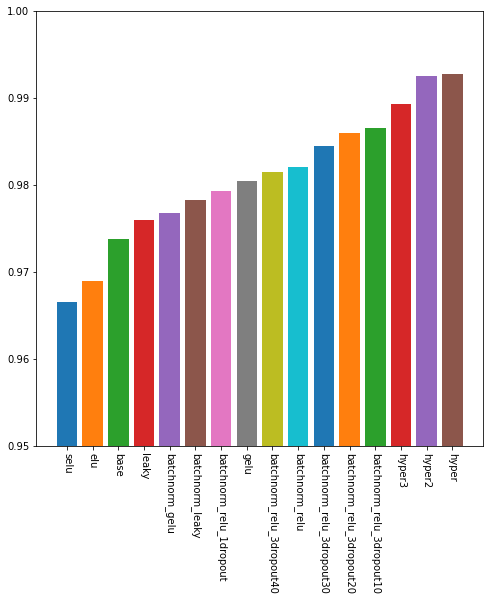

In [78]:
plot_scores(score, ymin=0.95)

# Save your model
After all this hard work and tuning, save your model.

In [ ]:
model.save('mymodel.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('mymodel.h5')

# Check its architecture
model.summary()

In [ ]:
model.evaluate(X_test, y_test)